# Automating screening of papers

Try and test different approaches and evalu which one of these is better.

I) Use text classification using embeddings

    a) Titles only
    b) Titles and abstracts only
    
Use Linear or non-linear methods to classify the documents.

II) Prompt negineering using Llama including

    a) Eligibility criteria (inclusion and exclusion criteria).
    b) Extract PICO and other necessary terms from the text (relevant features) and these can be used alongside the score to determine whether to include or not.


# Text classification using embeddings

In [19]:
# Install libraries
#!pip install scikit-learn
#!pip install cohere
#!pip install transformers
#!pip install torch
#!pip install torch torchvision
#!pip install matplotlib

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import altair as alt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

In [13]:
# Prepare the dataset
df_orig=pd.read_csv('https://raw.githubusercontent.com/cohere-ai/notebooks/main/notebooks/data/atis_intents_train.csv', names=['intent','query'])
df_orig

# Take a small sample for illustration purposes
sample_classes = ['atis_airfare', 'atis_airline', 'atis_ground_service']
df = df_orig.sample(frac=0.1, random_state=30)
df = df[df.intent.isin(sample_classes)]
df_orig = df_orig.drop(df.index)
df.reset_index(drop=True,inplace=True)

# Remove unnecessary column 
intents = df['intent'] #save for a later need
df.drop(columns=['intent'], inplace=True)

df

,query
0,which airlines fly from boston to washington ...
1,show me the airlines that fly between toronto...
2,show me round trip first class tickets from n...
3,i'd like the lowest fare from denver to pitts...
4,show me a list of ground transportation at bo...
...,...
86,what ground transportation is there in atlanta
87,can i take a single airline from la to charlo...
88,what is the cost for a one way trip from pitt...
89,what ground transportation is available in ba...


In [18]:

import cohere
co = cohere.ClientV2('wqQhRHfIEh22XrbYUKH95vlwLw9ViBktcwGaXUDf')

In [21]:
# Turn the text into embeddings
# Input; texts, model and input_type
def get_embeddings(texts, model="embed-english-v3.0", input_type="search_document"):
    output = co.embed(
        texts=texts, 
        model=model, 
        input_type=input_type, 
        embedding_types=["float"]
    )
    return output.embeddings.float

df['query_embeds'] = get_embeddings(df['query'].tolist())

In [22]:
df

,query,query_embeds
0,which airlines fly from boston to washington ...,"[0.02609253, 0.012168884, -0.008903503, 0.0114..."
1,show me the airlines that fly between toronto...,"[0.013801575, 0.017181396, -0.014984131, -0.00..."
2,show me round trip first class tickets from n...,"[0.02053833, -0.038482666, 0.061523438, 0.0099..."
3,i'd like the lowest fare from denver to pitts...,"[0.0016708374, 0.015625, -0.029022217, 0.03759..."
4,show me a list of ground transportation at bo...,"[0.037628174, -0.007888794, -0.0024662018, -0...."
...,...,...
86,what ground transportation is there in atlanta,"[0.014678955, 0.022964478, -0.020690918, -0.00..."
87,can i take a single airline from la to charlo...,"[-0.004180908, -0.031555176, -0.008918762, 0.0..."
88,what is the cost for a one way trip from pitt...,"[0.028198242, -0.015113831, 0.008026123, 0.009..."
89,what ground transportation is available in ba...,"[0.019744873, 0.012123108, -0.03164673, -0.027..."


In [23]:
# Decomposition of data to 10-dimensional version
# Function to return the principal components
def get_pc(arr, n):
    pca = PCA(n_components=n)
    embeds_transform = pca.fit_transform(arr)
    return embeds_transform
  
# Reduce embeddings to 10 principal components to aid visualization
embeds = np.array(df['query_embeds'].tolist())
embeds_pc = get_pc(embeds, 10)

In [27]:
# Visualise the embeddings with a heatmap
# Visualise the mebeddings on a 2D plot
# Lower dimensions retain lesser information, we humans are limited to 2D and 3D visualisations

In [9]:
# Using BERT a pretrained model to generate embeddings

from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np

# Load a pre-trained model tokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
model = AutoModel.from_pretrained('bert-base-uncased')
# Func
def  get_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt',padding=True,truncation=True)
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

def calculate_centroid(embeddings):
    return np.mean(embeddings,axis=0)



In [10]:
# input
#Pre-classified sentences
concrete_sentences = ['The role of adiposity in cardiometabolic traits: a Mendelian randomization analysis','Age- and sex-specific causal effects of adiposity on cardiovascular risk factors','Causal Effect of Adiposity Measures on Blood Pressure Traits in 2 Urban Swedish Cohorts: A Mendelian Randomization Study'
]
abstract_sentences = ['The causal effects of health conditions and risk factors on social and socioeconomic outcomes: Mendelian randomization in UK Biobank','Association of serum HDL-cholesterol and apolipoprotein A1 levels with risk of severe SARS-CoV-2 infection','Effect of Systolic Blood Pressure on Left Ventricular Structure and Function: A Mendelian Randomization Study']
# Getting embeddings
concrete_embeddings = [get_embedding(sent)for sent in concrete_sentences]

abstract_embeddings = [get_embedding(sent)for sent in abstract_sentences]
# Calculate the average locations (centroids)
concrete_centroid = calculate_centroid(concrete_embeddings)
abstract_centroid = calculate_centroid(abstract_embeddings)


In [11]:
# Classify a new sentence

new_sentence = 'Association between alcohol and cardiovascular disease: Mendelian randomisation analysis based on individual participant data.'
new_embedding = get_embedding(new_sentence)

# Measure distance to the centroids

distance_to_concrete = np.linalg.norm(new_embedding - concrete_centroid)
distance_to_abstract = np.linalg.norm(new_embedding - abstract_centroid)
print(distance_to_concrete)
print(distance_to_abstract)
# Classification
if distance_to_concrete < distance_to_abstract:
    classification = 'Concrete'
else:
    classification = 'Abstract'

print(classification)

4.0305705
4.5406876
Concrete


In [12]:
# Use a dimensionality reduction to visualise the embeddings
# Use t-SNE to reduce the embeddings from 768D to 2D


(6, 768)


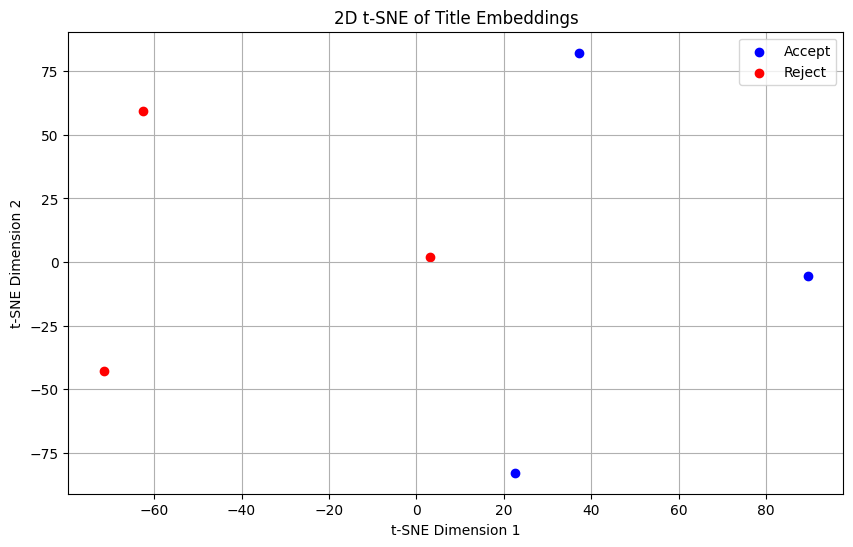

In [13]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

# Concatenate all embeddings
all_embeddings = np.concatenate((concrete_embeddings,abstract_embeddings),axis=0)

all_embeddings = np.squeeze(all_embeddings,axis=1)

print(all_embeddings.shape)

# Reduce the dimensionality
# Set the perplexity to a value less than the number of samples
perplexity_value = min(30, len(all_embeddings)-1)

#Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2,random_state=42,perplexity=perplexity_value)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Visualise the embeddings
num_concrete = len(concrete_embeddings)
# Plotting
plt.figure(figsize=(10,6))
plt.scatter(embeddings_2d[:num_concrete,0],embeddings_2d[:num_concrete,1],color='b',label='Accept')
plt.scatter(embeddings_2d[num_concrete:,0],embeddings_2d[num_concrete:,1],color='r',label='Reject')

plt.title("2D t-SNE of Title Embeddings")

plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Improve my code to use the BioBERT word embeddings